#Emotional Recognition on Twitter
##Using Bertweet on Airline Dataset

###Authored by Firoz Lakhani, Rohan Chaudary Mathew Forman


code has been used and modified from the following sources


https://github.com/pyhemza/BERTweet_sentiment_analysis

https://www.kaggle.com/code/mehmetlaudatekman/text-classification-svm-explained


In [ ]:
#constant values to be used throughout
RANDOM_SEED = 11
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"


In [ ]:
!pip3 install emoji
!pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score, precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

#initialize dataset, model, and tokenizer

df = pd.read_csv('AirlineTweets.csv')[['tweet_id', 'airline_sentiment', 'text']]

#data is split by 80% training and 20% validation
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

#lambda function assigns a numerical value to each sentiment
sentiment_to_numeric = lambda sentiment: {'negative': 0, 'neutral': 1, 'positive': 2}.get(sentiment.lower(), -1)

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
#Assigns 0 to negative, 1 to neutral, and 2 to positive
df_train['target'] = df_train.airline_sentiment.apply(sentiment_to_numeric)
df_val['target'] = df_val.airline_sentiment.apply(sentiment_to_numeric)
df_train


,tweet_id,airline_sentiment,text,target
718,570136977074491392,negative,@united LHR arrival lounge #fail. Waited 20 mi...,0
10379,569342681551400960,negative,@USAirways please help on hold 3 hours can't c...,0
3675,568191336764948480,negative,"@united, I'm still frustrated I gave up my sea...",0
10886,568803073835077632,neutral,@USAirways Thank you. But I don’t understand. ...,1
6785,570278619416694784,positive,@JetBlue Thanks for the quick reply! Just want...,2
...,...,...,...,...
4023,567868808586620928,negative,@united @annricord $856.81 the cost of one of ...,0
7259,569722876879884288,neutral,@JetBlue I understand delays. We are all look...,1
5200,569260462606569473,neutral,@SouthwestAir i like to see if i can change fl...,1
3775,568134171761065984,negative,@united get your act right! You just lost cust...,0


###Helper Functions and Classes

In [ ]:
#used for initializing a dataset object in pytorch
class AirlineTweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
#function is used for every epoch in training the model on dataset batches
#model updates parameters after every epoch and improves
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  #loads data batches from data loader and runs it through the model each time
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    #returns model predictions
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    #optimizes for the next step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #returns accuracy and average loss
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
#when model parameters are identified, the model is evaluated
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()

  losses = []
  correct_predictions = 0

  # runs through each batch in the dataset and evalulates the model
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      #get predictions and error
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  #returns accuracy and average loss
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#initializes our bert model which is used for classification
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bert_model.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = pooled_output
    return self.out(output)

In [ ]:
#returns prediction data for visualization purposes
def get_predictions(model, data_loader):
  model = model.eval()


  tweets_content = [] #stores contents of tweets
  predictions = []#stores model predictions
  prediction_probs = []#stores prediction probabilities
  real_values = []#stores actual values

  #gets data from tensor objects and stores them
  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets_content, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

###Model Training process

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 104

In [ ]:
df_train.shape, df_val.shape

((11712, 4), (2928, 4))

In [ ]:
#loads the datasets and creates dataloader objects to prepare for model


ds_train = AirlineTweetDataset(
        tweets=df_train.text.to_numpy(),
        targets=df_train.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

ds_val = AirlineTweetDataset(
        tweets=df_val.text.to_numpy(),
        targets=df_val.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

train_data_loader = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        num_workers=4
)

val_data_loader = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        num_workers=4
)
class_names = ['negative', 'neutral', 'positive']


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 104])
torch.Size([32, 104])


In [ ]:

EPOCHS = 30

#prepare for epoch training by initializing the scheduler and optimizer

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

#run through epochs until maximum accuracy is reached

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train loss 0.5041734838420576 accuracy 0.8014002732240437
Val   loss 0.3485074263551961 accuracy 0.8647540983606558

Epoch 2/30
----------
Train loss 0.3279724769660684 accuracy 0.8784153005464481
Val   loss 0.3566602756795676 accuracy 0.8644125683060109

Epoch 3/30
----------
Train loss 0.2707071787489405 accuracy 0.9012978142076503
Val   loss 0.36172998558891856 accuracy 0.8640710382513661

Epoch 4/30
----------
Train loss 0.21373290188427344 accuracy 0.9280225409836066
Val   loss 0.39537337636980024 accuracy 0.8691939890710383

Epoch 5/30
----------
Train loss 0.1711822179772082 accuracy 0.9444159836065574
Val   loss 0.4224465140344008 accuracy 0.8722677595628415

Epoch 6/30
----------
Train loss 0.1394060549321152 accuracy 0.9568818306010929
Val   loss 0.482450473162791 accuracy 0.8541666666666666

Epoch 7/30
----------
Train loss 0.11672633457827113 accuracy 0.9652493169398907
Val   loss 0.5092888353797405 accuracy 0.8555327868852459

Epoch 8/30
----------
Train loss 0.10126290170

In [ ]:
#gets prediction data
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)


#stores content in csv from numpy

predicted_values_np = y_pred.numpy()
actual_values_np = y_test.numpy()

# Concatenate predicted and actual values along the second axis (columns)
data = np.column_stack((predicted_values_np, actual_values_np))

# Specify the file path where you want to save the CSV file
file_path = "predicted_vs_actual.csv"

# Save the concatenated values to CSV file
np.savetxt(file_path, data, delimiter=",", header="Predicted, Actual", comments="")

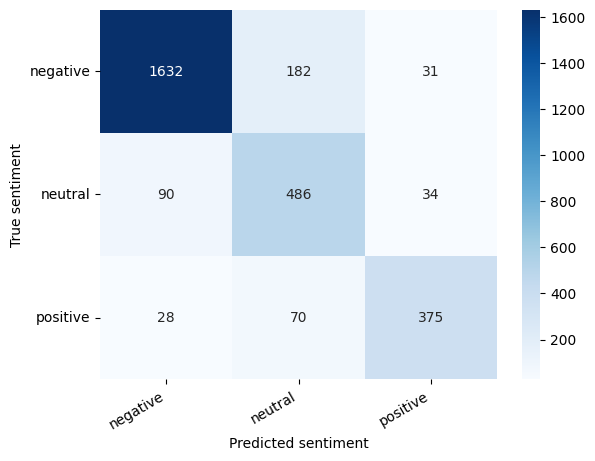

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.93      0.88      0.91      1845
     neutral       0.66      0.80      0.72       610
    positive       0.85      0.79      0.82       473

    accuracy                           0.85      2928
   macro avg       0.81      0.82      0.82      2928
weighted avg       0.86      0.85      0.86      2928



##Using Bertweet Embeddings with SVM for tweet classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch

In [ ]:
#allocates 80% of data for training and 20% for validation
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
encoded_training_inputs= tokenizer(list(df_train['text']), padding=True, truncation=True, return_tensors='pt')
encoded_validation_inputs = tokenizer(list(df_val['text']), padding=True, truncation=True, return_tensors='pt')

In [ ]:
# Get embeddings on training data
with torch.no_grad():
    output = bert_model(**encoded_training_inputs)

last_hidden_state = output.last_hidden_state
X_train_embeddings = last_hidden_state.mean(dim=1).squeeze().numpy()

# Get embeddings on validation data
with torch.no_grad():
    output = bert_model(**encoded_validation_inputs)

last_hidden_state = output.last_hidden_state
X_val_embeddings = last_hidden_state.mean(dim=1).squeeze().numpy()


In [ ]:
#Assigns 0 to negative, 1 to neutral, and 2 to positive
df_train['target'] = df_train.airline_sentiment.apply(sentiment_to_numeric)
df_val['target'] = df_val.airline_sentiment.apply(sentiment_to_numeric)

In [ ]:
from sklearn.svm import SVC
import time

#using the new bertweet embeddings, we train the model

start_time = time.time()

model = SVC()
model.fit(X_train_embeddings,df_train['target'])

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 31.44 seconds


In [ ]:
#generate predictions
predictions = model.predict(X_val_embeddings)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(df_val['target'],predictions) * 100))

Accuracy of model is 84.42622950819673%


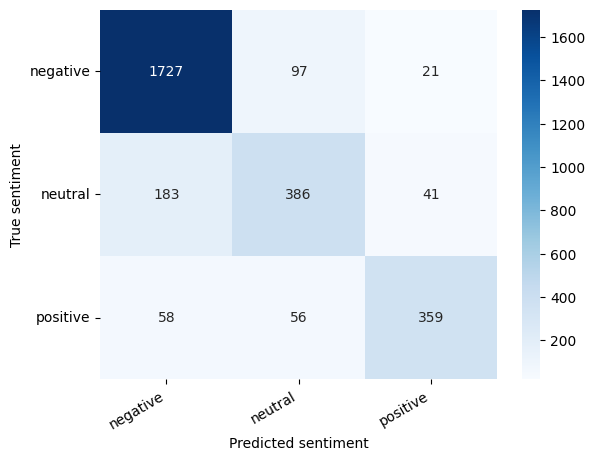

In [ ]:
class_names = ['negative', 'neutral', 'positive']
cm = confusion_matrix(df_val['target'], predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(df_val['target'], predictions, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.88      0.94      0.91      1845
     neutral       0.72      0.63      0.67       610
    positive       0.85      0.76      0.80       473

    accuracy                           0.84      2928
   macro avg       0.82      0.78      0.79      2928
weighted avg       0.84      0.84      0.84      2928



In [ ]:
result_df = pd.DataFrame({'Prediction': predictions, 'Actual': df_val['target']})
result_df.to_csv('Bert_svm_predictions.csv')